In [102]:
%pip install matplotlib numpy scipy spectral rich scikit-learn scikit-image opencv-python imbalanced-learn

Note: you may need to restart the kernel to use updated packages.


In [103]:
from matplotlib import pyplot as plt
import numpy as np
import sklearn
import sklearn.cluster
import spectral as spy
from rich import print
import os

# Purpose:

I'll aim to distinguish between western honey bees (*Apis mellifera*) and the *Varroa destructor* parasitic mite (Varroa mite) using hyperspectral imaging. Hyperspectral images capture a broad spectrum of radiation from each pixel, enabling this differentiation.

The dataset is available [here](https://www.kaggle.com/datasets/imonbilk/bee-dataset-but-hs).

In [104]:
experiment_dir = "MitesOnBess_Sparse"
image_id = "055"

path = os.path.join("/", os.getcwd(), "BeeDataset_BUT_HS", experiment_dir, "capture", f"{image_id}.hdr")
path

'/home/kapi/Programming/Hyperspectral/BeeDataset_BUT_HS/MitesOnBess_Sparse/capture/055.hdr'

In [105]:
img = spy.open_image(path)
hyperspectral_img = img.load()
hyperspectral_img = hyperspectral_img[50 : (hyperspectral_img.shape[0] // 2), 40:, :]
mean_image = np.mean(hyperspectral_img, axis=2)
rgb_image = spy.get_rgb(hyperspectral_img)

print(f"Hyperspectral image shape: {hyperspectral_img.shape}")
print(f"Mean image shape: {mean_image.shape}")
print(f"RGB image shape: {rgb_image.shape}")

Hyperspectral image shape: (206, 472, 204)

Mean image shape: (206, 472)

RGB image shape: (206, 472, 3)

## Approach 1.

### K-means Clustering

We will begin with one of the simplest unsupervised learning algorithms: **k-means clustering**. The goal is to determine which **cluster** each pixel belongs to, enabling us to distinguish between bees and parasites. 

In [106]:
def approach_1(hsi):
    # from (row, col, band) to (row x col, band)
    pixels = hsi.reshape(-1, hsi.shape[-1])
    # normalize the pixels
    pixels = pixels / np.max(pixels, axis=1, keepdims=True)

    print(f"Pixels shape: {pixels.shape}")

    n_clusters = 2
    kmeans = sklearn.cluster.KMeans(n_clusters)
    kmeans.fit(pixels)

    labeled_image = kmeans.labels_.reshape(hsi.shape[:2])

    mean_image = np.mean(hsi, axis=2)
    rgb_image = spy.get_rgb(hsi)

    fig, ax = plt.subplots(1, 3, figsize=(15, 15))
    ax[0].imshow(labeled_image, cmap="tab10")
    ax[0].set_title("Clustered Image")
    ax[0].axis("off")
    ax[1].imshow(mean_image)
    ax[1].set_title("Mean Image")
    ax[1].axis("off")
    ax[2].imshow(rgb_image)
    ax[2].set_title("RGB Image")
    ax[2].axis("off")
    plt.show()

    return kmeans.labels_.reshape(hsi.shape[:2])

    

Pixels shape: (97232, 204)

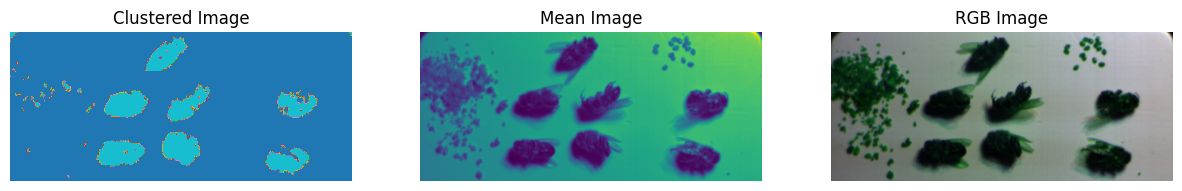

array([[1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32)

In [107]:
approach_1(hyperspectral_img)

The algorithm performed quite well overall. However, the shadows in the image posed a significant challenge. These likely disrupted the lighting and altered the radiation spectrum, leading to noticeable distortions around the edges of each segment. Potential solutions include splitting the image into smaller batches for processing or removing background noise to minimise interference.

It's important to note that this process is inherently random and may yield different results on each run. A cleaner, less noisy image would likely produce more consistent outcomes.

Additionally, this approach relies solely on spectral analysis. A more robust method would combine both spatial and spectral analysis to improve segmentation accuracy.

## Approach 2

Processed Image Shape: (206, 472, 204)

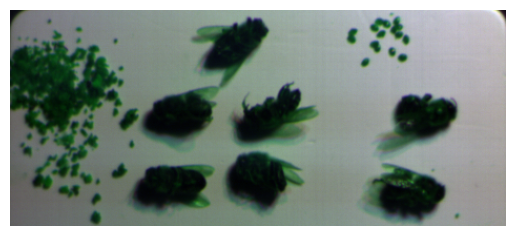

In [108]:
from sklearn.preprocessing import StandardScaler
import cv2
import matplotlib.pyplot as plt
import spectral as spy


def preprocess_image(hsi):
    scaler = StandardScaler()

    pixels = hsi.reshape(-1, hsi.shape[-1])
    pixels_scaled = scaler.fit_transform(pixels)
    pixels_scaled = pixels_scaled.reshape(hsi.shape)

    return pixels_scaled


ps = preprocess_image(hyperspectral_img)
print(f"Processed Image Shape: {ps.shape}")

rgb_ps = spy.get_rgb(ps)
plt.imshow(rgb_ps)
plt.axis("off")
plt.show()


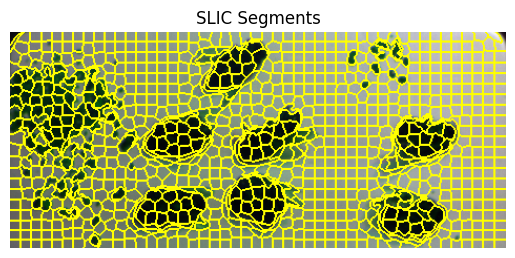

In [109]:
from skimage.segmentation import slic, mark_boundaries
from skimage.color import label2rgb
from skimage.graph import rag_mean_color, cut_threshold
import spectral as spy
import numpy as np
import matplotlib.pyplot as plt

def segmentize_image(hsi, n_segments=100, compactness=0.5, sigma=1, merge_thresh=0.05, visualize=True):
    segments = slic(hsi, n_segments=n_segments, compactness=compactness, sigma=sigma)

    rgb_i = spy.get_rgb(hsi) if hsi.shape[-1] > 3 else hsi[:, :, :3]

    # rag = rag_mean_color(rgb_i, segments)
    # labels = cut_threshold(segments, rag, merge_thresh)
    # out = label2rgb(labels, rgb_i, kind="overlay")

    # merged_segments = slic(out, n_segments=int(n_segments * 0.7), compactness=compactness*10, sigma=sigma)

    if visualize:
        plt.imshow(mark_boundaries(rgb_i, segments), cmap="tab10")
        plt.title("SLIC Segments")
        plt.axis("off")

        plt.show()

    # return merged_segments
    return segments

# Example usage
n_segments = 1000
merged_segments = segmentize_image(hsi=hyperspectral_img, n_segments=n_segments, visualize=True)


In [110]:
def fit_and_show(rgb_i, pixels_scaled, segments, n_clusters):
    unique_segments = np.unique(segments)
    n_segments = len(unique_segments)

    print(f"Number of segments: {n_segments}")
    features = []
    

    for segment in unique_segments:
        segment_mask = segments == segment
        # 2D array. Each row is a pixel in the segment
        segment_pixels = pixels_scaled[segment_mask]

        # segment's high order statistics of spectral features
        mean_spectrum = np.mean(segment_pixels, axis=0)
        std_spectrum = np.std(segment_pixels, axis=0)

        # segment's spatial features
        segment_size = np.sum(segment_mask)

        combined_features = np.concatenate([mean_spectrum, std_spectrum, [segment_size]])
        features.append(combined_features)

    features = np.array(features)
    features.shape # (n_segments, n_bands * 2)

    kmeans = sklearn.cluster.KMeans(n_clusters)
    kmeans.fit(features)

    labeled_image = np.zeros_like(segments)
    for i, segment in enumerate(unique_segments):
        segment_mask = segments == segment
        labeled_image[segment_mask] = kmeans.labels_[i]

    fig, ax = plt.subplots(1, 3, figsize=(15, 15))

    ax[0].imshow(labeled_image, cmap="tab10")
    ax[0].set_title("Clustered Image")
    ax[0].axis("off")
    ax[1].imshow(mark_boundaries(rgb_i, segments), cmap="tab10")
    ax[1].set_title("SLIC Segments")
    ax[1].axis("off")
    ax[2].imshow(rgb_i)
    ax[2].set_title("RGB Image")
    ax[2].axis("off")

    plt.show()

    return labeled_image.reshape(pixels_scaled.shape[:2])

In [111]:
def approach_2(hsi, n_clusters=2, n_segments=800):
    pixels_scaled = preprocess_image(hsi)
    rgb_i = spy.get_rgb(pixels_scaled)
    segments = segmentize_image(pixels_scaled, n_segments, visualize=False)
    return fit_and_show(rgb_i, pixels_scaled, segments, n_clusters)


Number of segments: 3709

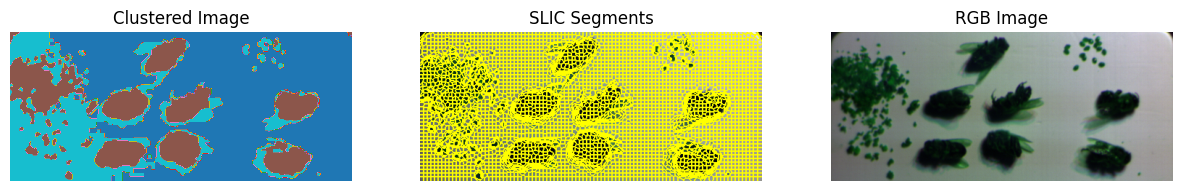

array([[1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       ...,
       [2, 2, 2, ..., 0, 0, 0],
       [2, 2, 2, ..., 0, 0, 0],
       [2, 2, 2, ..., 0, 0, 0]])

In [112]:
approach_2(hyperspectral_img, 3, 4000)

We can see that more detailed segmentation (more segments) can extract small and packed parasites. However it does very poorly on bigger objects like bees. 

Number of segments: 857

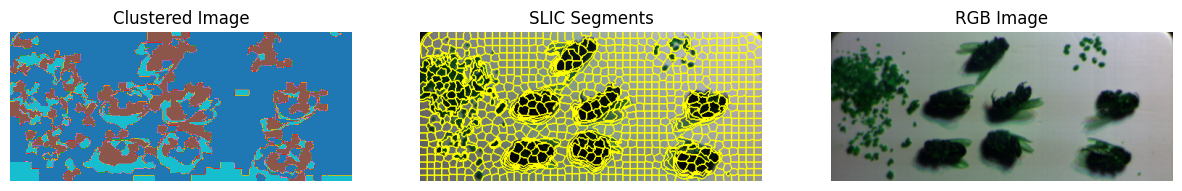

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [2, 2, 2, ..., 2, 2, 2],
       [2, 2, 2, ..., 2, 2, 2],
       [2, 2, 2, ..., 2, 2, 2]])

In [113]:
approach_2(hyperspectral_img, 3, 1000)

Lesser number of segments can classify bees pretty well. However it's unable to capture most spreaded out small objects as mites. 

Number of segments: 857

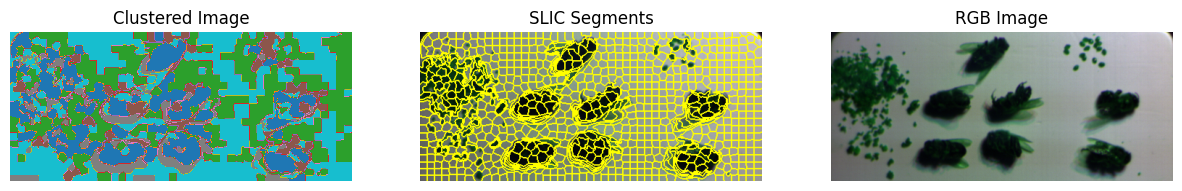

array([[4, 4, 4, ..., 1, 1, 1],
       [4, 4, 4, ..., 1, 1, 1],
       [4, 4, 4, ..., 1, 1, 1],
       ...,
       [3, 3, 3, ..., 4, 4, 4],
       [3, 3, 3, ..., 4, 4, 4],
       [3, 3, 3, ..., 4, 4, 4]])

In [114]:
approach_2(hyperspectral_img, 5, 1000)

It will be tough to find a reliable middleground for this task. We should look for another approaches.

## Approach 3

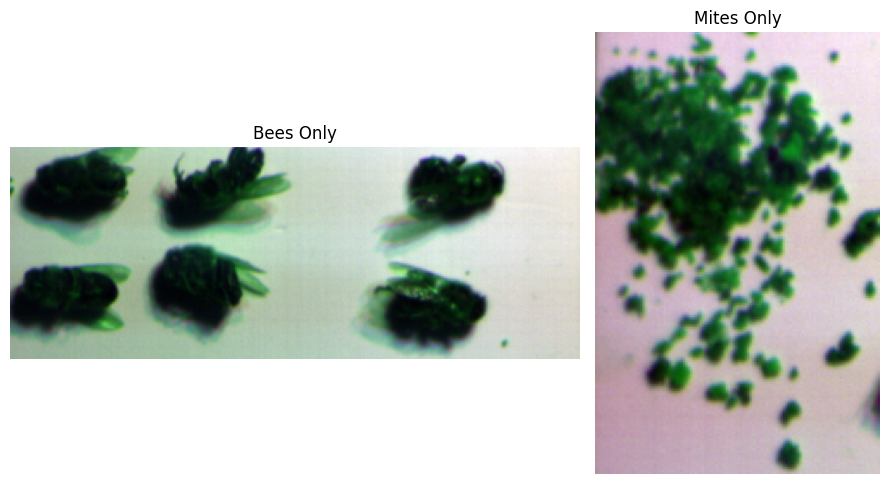

In [115]:
bees_only = hyperspectral_img[75:, 120:, :]
mites_only = hyperspectral_img[20:, :120, :]

bees_rgb = spy.get_rgb(bees_only)
mites_rgb = spy.get_rgb(mites_only)

fig, ax = plt.subplots(1, 2, figsize=(9, 6), gridspec_kw={'width_ratios': [2, 1]})

ax[0].imshow(bees_rgb)
ax[0].set_title("Bees Only")
ax[0].axis("off")

ax[1].imshow(mites_rgb)
ax[1].set_title("Mites Only")
ax[1].axis("off")

plt.tight_layout()
plt.show()

Pixels shape: (22320, 204)

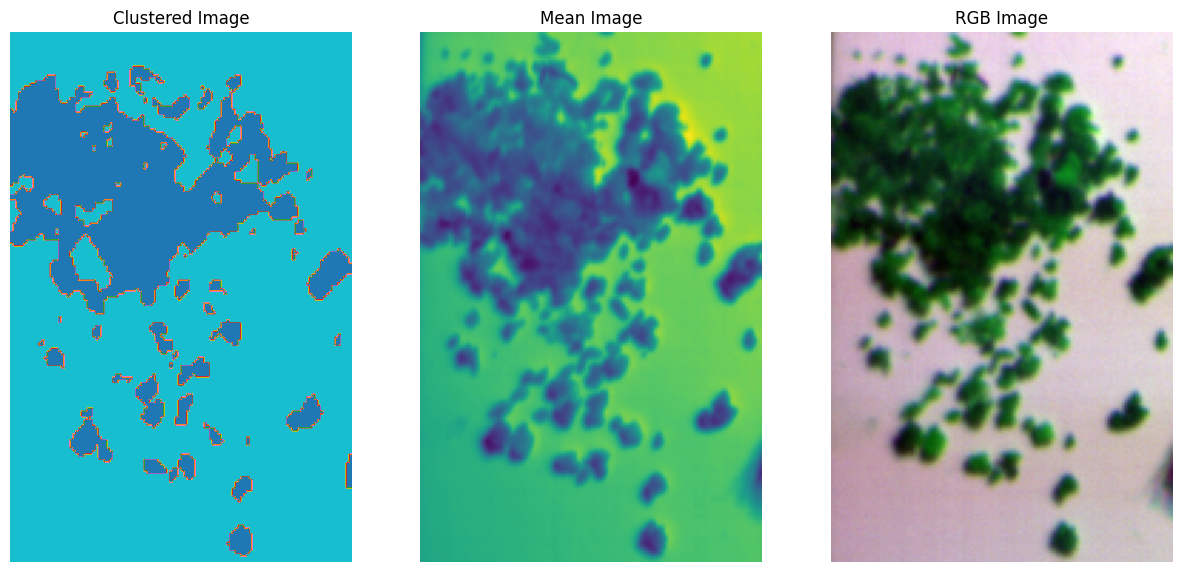

In [116]:
mites_labels = approach_1(mites_only)

In [117]:
mites_labels.shape

(186, 120)

Number of segments: 2864

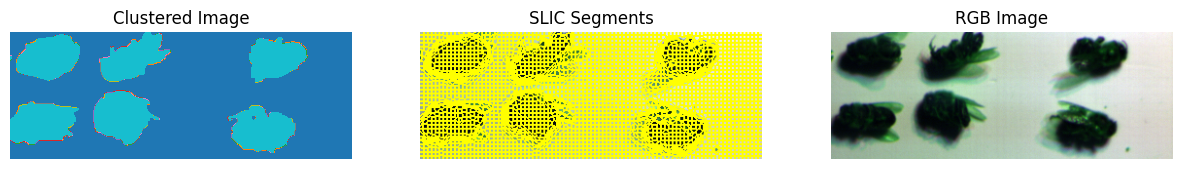

In [118]:
bees_labels = approach_2(bees_only, n_segments=3000)

In [119]:
bees_labels.shape

(131, 352)

In [120]:
bees_only.shape

(131, 352, 204)

In [121]:
bees_only.reshape(-1, bees_only.shape[-1]).shape

(46112, 204)

In [122]:
from typing import Counter

m_features = mites_only.reshape(-1, mites_only.shape[-1])
m_labels = mites_labels.reshape(-1)
m_labels = np.where((m_labels==0)|(m_labels==1), m_labels^1, m_labels)

b_features = bees_only.reshape(-1, bees_only.shape[-1])
b_labels = bees_labels.reshape(-1)
b_labels = b_labels * 2

In [123]:
features = np.concatenate([m_features, b_features])
labels = np.concatenate([m_labels, b_labels])

print(Counter(labels))

Counter({0: 49387, 1: 5614, 2: 13431})

In [124]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=42)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((54745, 204), (13687, 204), (54745,), (13687,))

In [125]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

clf = LogisticRegression(max_iter=1000)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)


print(classification_report(y_test, y_pred))

/home/kapi/Programming/Hyperspectral/.venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


precision    recall  f1-score   support

           0       0.99      0.99      0.99      9894
           1       0.95      0.92      0.93      1119
           2       0.95      0.95      0.95      2674

    accuracy                           0.98     13687
   macro avg       0.96      0.95      0.96     13687
weighted avg       0.98      0.98      0.98     13687

In [126]:
hyperspectral_img.shape

(206, 472, 204)

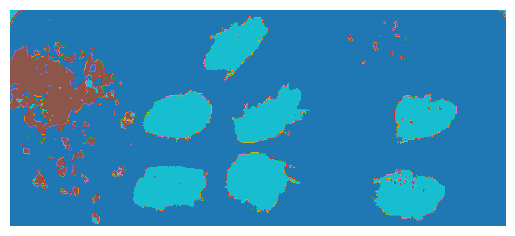

In [127]:
pixels = hyperspectral_img.reshape(-1, hyperspectral_img.shape[-1])

classified_image = clf.predict(pixels).reshape(hyperspectral_img.shape[:2])

plt.imshow(classified_image, cmap="tab10")
plt.axis("off")
plt.show()

In [128]:
from imblearn.over_sampling import SMOTE
smote = SMOTE(random_state=42)
features_resampled, labels_resampled = smote.fit_resample(features, labels)

print(Counter(labels_resampled))

features_resampled.shape

Counter({0: 49387, 1: 49387, 2: 49387})

(148161, 204)

In [129]:
X_train, X_test, y_train, y_test = train_test_split(features_resampled, labels_resampled, test_size=0.2, random_state=42)

clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

print(classification_report(y_test, y_pred))

/home/kapi/Programming/Hyperspectral/.venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


precision    recall  f1-score   support

           0       0.98      0.97      0.98      9822
           1       0.98      0.98      0.98      9836
           2       0.97      0.98      0.97      9975

    accuracy                           0.98     29633
   macro avg       0.98      0.98      0.98     29633
weighted avg       0.98      0.98      0.98     29633

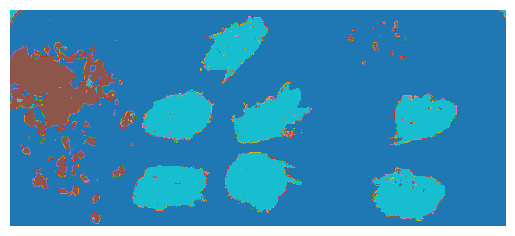

In [130]:
pixels = hyperspectral_img.reshape(-1, hyperspectral_img.shape[-1])

classified_image = clf.predict(pixels).reshape(hyperspectral_img.shape[:2])

plt.imshow(classified_image, cmap="tab10")
plt.axis("off")
plt.show()